In [205]:
import geopandas as gpd
import pandas as pd
pd.options.display.max_columns = None
import statsmodels.api as sm
import zipfile

import numpy as np

# read in the shapefile of buncome parcels
parcels = gpd.read_file("./data/Buncombe_County_Parcels/Buncombe_County_Parcels.zip") 
print(parcels.columns)
print(len(parcels))
# read in the CSV file 
zf = zipfile.ZipFile('./data/Appraisal_Tax_History2022/Real_Estate_Appraisal_Tax_History_2022.zip') 
appraisal_tax_history = pd.read_csv(zf.open('Real_Estate_Appraisal_Tax_History_2022.csv'))

# appraisal_tax_history = pd.read_csv("./data/Appraisal_Tax_History2022/Real_Estate_Appraisal_Tax_History_2022.zip",compression='zip') 
print(len(appraisal_tax_history))


Index(['PIN', 'Owner', 'NmpType', 'TaxYear', 'CondoUnit', 'CondoBuild',
       'DeedBook', 'DeedPage', 'PlatBook', 'PlatPage', 'SubName', 'SubLot',
       'SubBlock', 'SubSect', 'UpdateDate', 'HouseNumbe', 'NumberSuff',
       'StreetName', 'StreetType', 'Township', 'Acreage', 'AccountNum',
       'DeedDate', 'Stamps', 'Instrument', 'Reason', 'County', 'City',
       'FireDistri', 'SchoolDist', 'CareOf', 'Address', 'CityName', 'State',
       'Zipcode', 'Class', 'Improved', 'Exempt', 'Priced', 'TotalMarke',
       'AppraisedV', 'TaxValue', 'LandUse', 'Neighborho', 'LandValue',
       'BuildingVa', 'AppraisalA', 'PropCard', 'StreetPref', 'StreetPost',
       'SalePrice', 'objectid', 'ESRI_OID', 'geometry'],
      dtype='object')
131856


/var/folders/hy/304lry6j4sbbkk4_rs_vfdw80000gn/T/ipykernel_18900/840337364.py:15: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  appraisal_tax_history = pd.read_csv(zf.open('Real_Estate_Appraisal_Tax_History_2022.csv'))


2491791


In [206]:
# Single family
# 'RES 0-3 ACRES', 'RES >3 ACRES', 'CONDO','TOWNHOME', 'MFG HOME SITE'
parcels =parcels.loc[parcels['Class'].isin(['100','101','120','121','170'])]
print(len(parcels))
parcels_len=len(parcels)

91179


In [207]:
#  For now I'm justing looking a the percent change from 2020 to 2021
appraisal_tax_history = appraisal_tax_history.loc[appraisal_tax_history['TaxYear'] >= 2020]

# Filtering for tax history records that have a PIN in the parcel database
# this might help with computation load for the merge we'll do later
appraisal_tax_history = appraisal_tax_history[appraisal_tax_history['PIN'].isin(parcels['PIN'])] 

# Calculating total valuation from land and bldg valuation. 
appraisal_tax_history['TotalVal'] = appraisal_tax_history['LandVal']+appraisal_tax_history['BldgVal']

#calculate percent change
appraisal_tax_history = appraisal_tax_history.sort_values(by=['PIN','TaxYear'])
appraisal_tax_history['land_value_pct_change'] = appraisal_tax_history.groupby('PIN')['LandVal'].pct_change(periods=1)
appraisal_tax_history['building_value_pct_change'] = appraisal_tax_history.groupby('PIN')['BldgVal'].pct_change(periods=1) 
appraisal_tax_history['total_value_pct_change'] = appraisal_tax_history.groupby('PIN')['TotalVal'].pct_change(periods=1) 


In [208]:
appraisal_tax_history = appraisal_tax_history.loc[appraisal_tax_history['TaxYear'] == 2021.0]
print(len(appraisal_tax_history))

83280


In [209]:

# User inner join here to only anlayse properties that I have a rate change for
# this is to avoid possible parcels that have been recently created, so i don't peg them as having not 
# paid a bill without having been around for the rate increase
merged_data = parcels.merge(appraisal_tax_history, how='inner', left_on='PIN', right_on='PIN')
print(len(merged_data))

merged_data_length_with_percent_change = len(merged_data)
merged_data.head(2)

83280


,PIN,Owner,NmpType,TaxYear_x,CondoUnit,CondoBuild,DeedBook,DeedPage,PlatBook,PlatPage,SubName,SubLot,SubBlock,SubSect,UpdateDate,HouseNumbe,NumberSuff,StreetName,StreetType,Township,Acreage,AccountNum,DeedDate,Stamps,Instrument,Reason,County,City,FireDistri,SchoolDist,CareOf,Address,CityName,State,Zipcode,Class,Improved,Exempt,Priced,TotalMarke,AppraisedV,TaxValue,LandUse,Neighborho,LandValue,BuildingVa,AppraisalA,PropCard,StreetPref,StreetPost,SalePrice,objectid,ESRI_OID,geometry,TaxYear_y,PinOwner,Acres,LandVal,BldgVal,ImprVal,ExemVal,DfrdVal,Exemption,OBJECTID,TotalVal,land_value_pct_change,building_value_pct_change,total_value_pct_change
0,060503100000000,STONE ROBERT K;STONE REBECCA,NaN,24,None,None,1340,0496,0000,0000,None,None,None,None,20230117,23,None,BUTTERROW COVE,RD,20,1.69,69436531;69436532,19710706,1.0,DEE,None,BUN,None,FFA,None,None,23 BUTTERROW COVE RD,FAIRVIEW,NC,28730,100,Y,None,None,296000,296000,296000,None,TSTD,61100,233900,5,http://prc-buncombe.spatialest.com/#/property/...,None,None,1000,121558,74153,"POLYGON ((-82.36073 35.49799, -82.36057 35.497...",2021.0,69436531.0,1.69,61100.0,233900.0,1000.0,0.0,0.0,0,59,295000.0,0.0,0.096064,0.074681
1,060503128800000,MOLLY HAMILTON TRUST,NaN,24,None,None,6282,559,0104,0149,SUGAR HOLLOW ORCHARDS,3,None,None,20230117,5,None,SUGAR HOLLOW ORCHARD,DR,20,1.50,82925343,20221212,0.0,WDT,None,BUN,None,FFA,None,None,5 SUGAR HOLLOW ORCHARD DR,FAIRVIEW,NC,28730,100,Y,None,None,474200,474200,474200,None,SUOA,120000,354200,5,http://prc-buncombe.spatialest.com/#/property/...,None,None,0,76153,74154,"POLYGON ((-82.35906 35.49882, -82.35946 35.498...",2021.0,82248521.0,1.50,120000.0,354200.0,0.0,0.0,0.0,0,75,474200.0,0.0,0.095238,0.069463


In [210]:

unpaid_bills = pd.read_csv("./data/Unpaid_Property_Bills2022/Unpaid_Property_Bills_from_2022.csv")
# This will help identify properties with an unpaid bill, after merging the data.
unpaid_bills['unpaid_bill']=True

print(len(unpaid_bills))
print(len(merged_data))
print(len(parcels))


# Remove leading and trailing white spaces from the "address_line1", "city", "postal_code", "ADDRESS", "CITYNAME", and "ZIPCODE" columns
unpaid_bills['pin'] = unpaid_bills['pin'].str.strip()
merged_data['PIN'] = merged_data['PIN'].str.strip()
parcels['PIN'] = parcels['PIN'].str.strip()

unpaid_bills = unpaid_bills.rename(columns={'pin': 'PIN'})

unpaid_bills['PIN'] = unpaid_bills['PIN'].fillna(value='')
merged_data['PIN'] = merged_data['PIN'].fillna(value='')
parcels['PIN'] = parcels['PIN'].fillna(value='')

unpaid_bills['PIN'] = unpaid_bills['PIN'].astype(str)
merged_data['PIN'] = merged_data['PIN'].astype(str)
parcels['PIN'] = parcels['PIN'].astype(str)

print(len(merged_data))
print('unpaid_bills: ',len(unpaid_bills))

print( unpaid_bills['PIN'].dtype)
print(merged_data['PIN'].dtype)
print( parcels['PIN'].dtype)

# Sort the dataframes on the join column "PIN"
merged_data.sort_values("PIN", inplace=True)
unpaid_bills.sort_values("PIN", inplace=True)
parcels.sort_values("PIN", inplace=True)

#merge left 
merged_data = merged_data.join(unpaid_bills, how='left',
                               lsuffix='', rsuffix='_y', sort=False)
print(len(merged_data))

parcels = parcels.join(unpaid_bills, how='left',
                               lsuffix='', rsuffix='_y', sort=False)
print(len(parcels))

# Originally I had thought to try a secondary merge on address columns,
# because there are many unpaid bills without a 'PIN'
# but a gentelman at the county GIS office told me that unpaid bills with
# a pin would be real-estate related, while thouse without it might be a 
# different type of property. Keeping this here to save the idea.

# unpaid_bills['pin'] = unpaid_bills['pin'].str.replace("-", "")
# unpaid_bills['postal_code'] = unpaid_bills['postal_code'].astype(str)
# unpaid_bills['postal_code'] = unpaid_bills['postal_code'].astype(object)

# print(merged_data[["Address", "CityName", "Zipcode"]].dtypes)
# print(merged_data['PIN'].dtype)
# print(unpaid_bills['pin'].dtype)
# print(unpaid_bills[["address_line1", "city", "postal_code"]].dtypes)
# unpaid_bills['address_line1']=unpaid_bills['address_line1']+unpaid_bills['address_line2']
# unpaid_bills['address_line1'] = unpaid_bills['address_line1'].str.strip()
# unpaid_bills['city'] = unpaid_bills['city'].str.strip()
# unpaid_bills['postal_code'] = unpaid_bills['postal_code'].str.strip()
# merged_data['Address'] = merged_data['Address'].str.strip()
# merged_data['CityName'] = merged_data['CityName'].str.strip()
# merged_data['Zipcode'] = merged_data['Zipcode'].str.strip()

# # Convert the "address_line1", "city", "postal_code", "ADDRESS", "CITYNAME", and "ZIPCODE" columns to lowercase
# unpaid_bills['address_line1'] = unpaid_bills['address_line1'].str.lower()
# unpaid_bills['city'] = unpaid_bills['city'].str.lower()
# unpaid_bills['postal_code'] = unpaid_bills['postal_code'].str.lower()
# merged_data['Address'] = merged_data['Address'].str.lower()
# merged_data['CityName'] = merged_data['CityName'].str.lower()
# merged_data['Zipcode'] = merged_data['Zipcode'].str.lower()

#Secondary merge on "Address", "CityName", "Zipcode" and "address_line1", "city", "postal_code"
# merged_data_no_pin = merged_data_no_pin.merge(unpaid_bills, how='left', 
#                                 left_on=['Address', 'CityName'], 
#                                 right_on=['address_line1', 'city'])

# print(len(merged_data_no_pin))
# merged_data = pd.concat([merged_data_no_pin,merged_data]) 
print(len(merged_data))
print(len(parcels))
merged_data['unpaid_bill']=merged_data['unpaid_bill'].fillna(value=False)
parcels['unpaid_bill']=parcels['unpaid_bill'].fillna(value=False)
merged_data.head(2)

21369
83280
91179


/var/folders/hy/304lry6j4sbbkk4_rs_vfdw80000gn/T/ipykernel_18900/949531891.py:1: DtypeWarning: Columns (12,21,49) have mixed types. Specify dtype option on import or set low_memory=False.
  unpaid_bills = pd.read_csv("./data/Unpaid_Property_Bills2022/Unpaid_Property_Bills_from_2022.csv")


83280
unpaid_bills:  21369
object
object
object
83280
91179
83280
91179


,PIN,Owner,NmpType,TaxYear_x,CondoUnit,CondoBuild,DeedBook,DeedPage,PlatBook,PlatPage,SubName,SubLot,SubBlock,SubSect,UpdateDate,HouseNumbe,NumberSuff,StreetName,StreetType,Township,Acreage,AccountNum,DeedDate,Stamps,Instrument,Reason,County,City,FireDistri,SchoolDist,CareOf,Address,CityName,State,Zipcode,Class,Improved,Exempt,Priced,TotalMarke,AppraisedV,TaxValue,LandUse,Neighborho,LandValue,BuildingVa,AppraisalA,PropCard,StreetPref,StreetPost,SalePrice,objectid,ESRI_OID,geometry,TaxYear_y,PinOwner,Acres,LandVal,BldgVal,ImprVal,ExemVal,DfrdVal,Exemption,OBJECTID,TotalVal,land_value_pct_change,building_value_pct_change,total_value_pct_change,acres,active_flag,ad_cost_due,address_line1,address_line2,bill,city,city_code,cost_due,deed_book,deed_date,deed_instrument,deed_page,deferred_value,exempt_value,fees_due,fire_code,house_num,house_suf,interest_due,late_due,levy_due,levy_year,loan_num,mortgage_co,original_bill_amount,owner1_first_name,owner1_last_name,owner1_suffix_name,owner1_third_name,owner2_first_name,owner2_last_name,owner2_suffix_name,owner2_third_name,personal_value,PIN_y,plat_book,plat_page,postal_code,postal_code_ext,real_value,school_code,state,street_direction,street_name,street_type,sub_lot,subdivision,tax_due,total_due,total_value,township,OBJECTID_y,unpaid_bill
0,060503100000000,STONE ROBERT K;STONE REBECCA,NaN,24,None,None,1340,0496,0000,0000,None,None,None,None,20230117,23,None,BUTTERROW COVE,RD,20,1.69,69436531;69436532,19710706,1.0,DEE,None,BUN,None,FFA,None,None,23 BUTTERROW COVE RD,FAIRVIEW,NC,28730,100,Y,None,None,296000,296000,296000,None,TSTD,61100,233900,5,http://prc-buncombe.spatialest.com/#/property/...,None,None,1000,121558,74153,"POLYGON ((-82.36073 35.49799, -82.36057 35.497...",2021.0,69436531.0,1.69,61100.0,233900.0,1000.0,0.0,0.0,0,59,295000.0,0.0,0.096064,0.074681,NaN,NaN,0.0,11 PINE ISLAND DR,NaN,0000762296-2022-2022-0000-00,CANDLER,NaN,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,FEC,0.0,0,0.0,26.34,289.74,2022.0,NaN,NaN,289.74,JOSEPH,CHESTER,NaN,NaN,NaN,NaN,NaN,NaN,44419.0,,NaN,NaN,28715.0,8184.0,0.0,NaN,NC,NaN,NaN,NaN,NaN,NaN,263.40,289.74,44419.0,NaN,15036.0,True
1,060503128800000,MOLLY HAMILTON TRUST,NaN,24,None,None,6282,559,0104,0149,SUGAR HOLLOW ORCHARDS,3,None,None,20230117,5,None,SUGAR HOLLOW ORCHARD,DR,20,1.50,82925343,20221212,0.0,WDT,None,BUN,None,FFA,None,None,5 SUGAR HOLLOW ORCHARD DR,FAIRVIEW,NC,28730,100,Y,None,None,474200,474200,474200,None,SUOA,120000,354200,5,http://prc-buncombe.spatialest.com/#/property/...,None,None,0,76153,74154,"POLYGON ((-82.35906 35.49882, -82.35946 35.498...",2021.0,82248521.0,1.50,120000.0,354200.0,0.0,0.0,0.0,0,75,474200.0,0.0,0.095238,0.069463,0.71,1.0,0.0,PO BOX 253,NaN,0000708341-2022-2022-0000-00,RIDGECREST,NaN,0.0,1279,1981/08/26,NON,289,0.0,0.0,0.0,FEB,36.0,NaN,0.0,0.00,429.52,2022.0,NaN,NaN,429.52,DAVID,HALL,NaN,E,THERESA,HALL,NaN,NaN,0.0,0629-48-5739-00000,32,47,28770.0,253.0,72200.0,NaN,NC,NaN,LOCUST,ST,255,RIDGECREST,429.52,429.52,72200.0,NaN,18068.0,True


In [211]:
merged_data["total_due"].value_counts(dropna=False)

NaN       61911
32.99        32
23.07        31
21.96        29
30.00        21
          ...  
558.95        1
975.20        1
277.52        1
83.23         1
56.91         1
Name: total_due, Length: 17712, dtype: int64

In [212]:
merged_data["Class"].value_counts(dropna=False)

100    62298
170     8336
101     4897
120     4409
121     3340
Name: Class, dtype: int64

In [215]:
merged_data['unpaid_bill'].value_counts(dropna=False)
# Lingering question: If your taxeble value changes in 2021 
# when is the first time you'd pay taxes on the new amount? 
# I'm using billing data from 2022 beacuse, to be on the safer side.

False    61911
True     21369
Name: unpaid_bill, dtype: int64

In [216]:
# Check how many preperties don't have a percent change
print(len(merged_data))
print(merged_data_length_with_percent_change)
merged_data["total_value_pct_change"].value_counts(dropna=False)

83280
83280


NaN         1394
0.000000     428
0.371257      64
0.319672      62
0.250000      57
            ... 
0.200411       1
0.221501       1
0.229254       1
0.217112       1
0.344164       1
Name: total_value_pct_change, Length: 72754, dtype: int64

In [217]:
# only want to look at houses for which I hav a percent incerase
merged_data = merged_data[~merged_data["total_value_pct_change"].isnull()]
merged_data["total_value_pct_change"].value_counts(dropna=False)

0.000000    428
0.371257     64
0.319672     62
0.250000     57
0.621475     56
           ... 
0.200411      1
0.221501      1
0.229254      1
0.217112      1
0.344164      1
Name: total_value_pct_change, Length: 72753, dtype: int64

In [218]:
import statsmodels.api as sm

print(merged_data[['total_value_pct_change','unpaid_bill']].isna().sum())
# Prepare the data

# quick check for inf values
df = merged_data[['total_value_pct_change','unpaid_bill']]
number_inf = df[df == np.inf].count()
print(number_inf)

# prepare data from regression
merged_data['total_value_pct_change'].replace([np.inf, -np.inf], np.nan, inplace=True)
merged_data.dropna(subset=["total_value_pct_change"], how="all", inplace=True)

# Multiply to make coef easier to interpret. 
merged_data['total_value_pct_change'] = merged_data['total_value_pct_change']*100


X = merged_data['total_value_pct_change']
print(len(X))
y = merged_data['unpaid_bill']
print(len(y))
# Fit the logistic regression model
logit = sm.Logit(y, X)
result = logit.fit()
print(result.summary())

# I still need to check for linearity


total_value_pct_change    0
unpaid_bill               0
dtype: int64
total_value_pct_change    1
unpaid_bill               0
dtype: int64
81885
81885
Optimization terminated successfully.
         Current function value: 0.649529
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            unpaid_bill   No. Observations:                81885
Model:                          Logit   Df Residuals:                    81884
Method:                           MLE   Df Model:                            0
Date:                Fri, 27 Jan 2023   Pseudo R-squ.:                 -0.1420
Time:                        18:16:37   Log-Likelihood:                -53187.
converged:                       True   LL-Null:                       -46574.
Covariance Type:            nonrobust   LLR p-value:                       nan
                             coef    std err          z      P>|z|      [0.025      0.975]
-------------------------

<AxesSubplot: xlabel='total_value_pct_change', ylabel='unpaid_bill'>

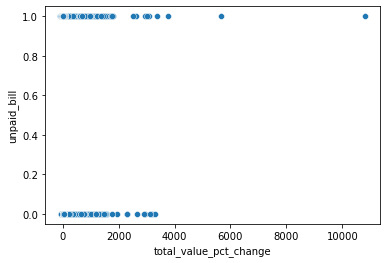

In [219]:
import seaborn as sns
sns.scatterplot(x='total_value_pct_change', y='unpaid_bill', data=merged_data)

In [220]:
# top_10_highest_values = merged_data.nlargest(5, 'TotalVal')
# top_10_highest_values

In [221]:
quintiles = merged_data['TotalVal'].quantile([0, 0.2, 0.4, 0.6, 0.8, 1])
array_q = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5']
merged_data['TotalVal_quintile'] = pd.cut(merged_data['TotalVal'], quintiles, labels=array_q)

# Loop through quintiles and run a logistic regression
for quintile in array_q:
    merged_data_quintile = merged_data[merged_data['TotalVal_quintile'] == quartile]
    Xx = merged_data_quartile['total_value_pct_change']
    Yy = merged_data_quartile['unpaid_bill']
    print(f'Coefficients for quintile {quartile}')
    logit = sm.Logit(Yy, Xx)
    result = logit.fit()
    print(result.summary())
    

Coefficients for quintile Q5
Optimization terminated successfully.
         Current function value: 0.634020
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:            unpaid_bill   No. Observations:                 3959
Model:                          Logit   Df Residuals:                     3958
Method:                           MLE   Df Model:                            0
Date:                Fri, 27 Jan 2023   Pseudo R-squ.:                 -0.2291
Time:                        18:16:37   Log-Likelihood:                -2510.1
converged:                       True   LL-Null:                       -2042.2
Covariance Type:            nonrobust   LLR p-value:                       nan
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
total_value_pct_change    -0.0242      0.001    -17.549

In [222]:
#  total unpaid bill rate
merged_data['unpaid_bill'].mean()

0.2559443121450815

In [223]:
# Here I'm checking to see which quintiles have more unpaid bills.
#switching back to using all parcels to include those I filtered out
#when cleaning for the previous section, but an argument could probably be made to use either.
print(len(parcels))
quintiles = parcels['TaxValue'].quantile([0, 0.2, 0.4, 0.6, 0.8, 1])
array_q = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5']
parcels['TaxVal_quintile'] = pd.cut(parcels['TaxValue'], quintiles, labels=array_q)


grouped_quintiles = parcels.groupby('TaxVal_quintile')

# Get the raw number of true 'unpaid_bill' variables in each quintile
raw_counts_quintiles = grouped_quintiles['unpaid_bill'].sum()

# Get the total number of records in each quintile
total_counts_quintiles = grouped_quintiles['TaxValue'].count()

# Get the ratio of true 'unpaid_bill' variables in each quintile
ratio_quintiles = raw_counts / total_counts
print('\n --------')
print('Raw totals quintiles:')
print(raw_counts_quintiles)
print('\n --------')
print('Total_counts quintiles:')
print(total_counts_quintiles)
print('\n --------')
print('rate raw_counts / total_counts by quintile:')
print(ratio_quintiles)

print(parcels.groupby('TaxVal_quintile')['unpaid_bill'].value_counts(dropna=False))
parcels.groupby('TaxVal_quintile')['unpaid_bill'].agg(['count', 'sum', 'mean'])

91179

 --------
Raw totals quintiles:
TaxVal_quintile
Q1    3636
Q2    2779
Q3    2333
Q4    2305
Q5    1666
Name: unpaid_bill, dtype: int64

 --------
Total_counts quintiles:
TaxVal_quintile
Q1    17072
Q2    18273
Q3    18203
Q4    18236
Q5    18230
Name: TaxValue, dtype: int64

 --------
rate raw_counts / total_counts by quintile:
TotalVal_quintile
Q1    0.375969
Q2    0.252001
Q3    0.229149
Q4    0.220547
Q5    0.201918
dtype: float64
TaxVal_quintile  unpaid_bill
Q1               False          13436
                 True            3636
Q2               False          15494
                 True            2779
Q3               False          15870
                 True            2333
Q4               False          15931
                 True            2305
Q5               False          16564
                 True            1666
Name: unpaid_bill, dtype: int64


,count,sum,mean
TaxVal_quintile,,,
Q1,17072,3636,0.212980
Q2,18273,2779,0.152082
Q3,18203,2333,0.128166
Q4,18236,2305,0.126398
Q5,18230,1666,0.091388


In [224]:
# Doing the same thing here for all deciles
deciles = parcels['TaxValue'].quantile([0,0.1, 0.2,0.3, 0.4,0.5, 0.6,0.7, 0.8,0.9, 1])
parcels['TaxVal_deciles'] = pd.cut(parcels['TaxValue'], deciles, labels=['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10'])


grouped_deciles = parcels.groupby('TaxVal_deciles')

# Get the raw number of true 'unpaid_bill' variables in each decile
raw_counts_deciles = grouped_deciles['unpaid_bill'].sum()

# Get the total number of records in each decile
total_counts_deciles = grouped_deciles['TaxValue'].count()

# Get the ratio of true 'unpaid_bill' variables in each decile
ratio_deciles = raw_counts_deciles / total_counts_deciles
print('Deciles\n --------')
print('Raw totals:')
print(raw_counts_deciles)
print('\n --------')
print('Total_counts:')
print(total_counts_deciles)
print('\n --------')
print('rate raw_counts / total_counts:')
print(ratio_deciles)

print(parcels.groupby('TaxVal_deciles')['unpaid_bill'].value_counts(dropna=False))
parcels.groupby('TaxVal_deciles')['unpaid_bill'].agg(['count', 'sum', 'mean'])

KeyError: 'Column not found: TaxVal'

In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# from statsmodels.formula.api import logit

# # Fit the logistic regression model
# # model = logit('unpaid_bill ~ total_value_pct_change', data=merged_data)
# # result = model.fit()

# # Create a scatter plot of the residuals vs predicted values
# predictions = result.predict(merged_data[['total_value_pct_change','unpaid_bill']])
# residuals = merged_data['unpaid_bill'] - predictions
# plt.scatter(predictions, residuals)
# plt.xlabel('Predicted Values')
# plt.ylabel('Residuals')
# plt.show()

# # Create a histogram of the residuals
# sns.histplot(residuals)
# plt.xlabel('Residuals')
# plt.ylabel('Frequency')
# plt.show()

# # Create a Q-Q plot of the residuals
# import scipy.stats as stats
# res = result.resid_pearson 
# stats.probplot(res, dist="norm", plot=plt)
# plt.show()
